## SMS Text Classification
#### Section 2 : Prof. Tanya Roosta

### Members:
#### Hillary Chang, hillary_chang@berkeley.edu
#### Raji Chandrasekaran,  raji.chandrasekaran@berkeley.edu
#### Song Gao, song_gao@berkeley.edu


### Motivation

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

random.seed(2)


2025-06-19 10:28:29.557326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/raji/Documents/207 Python/jupyter-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
df = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=["label", "message"])

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Initial data counts
print(df.shape)
print(df['label'].value_counts())

(5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
# converting labels to numeric identifiers
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [7]:
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


#### The message contains punctuations and uppercase and lowercase and spaces. We will need to standardize this using string pre processing. The folllowing function will handle all string pre processing needs

In [9]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [nltk]━━━━━━━━━━━━━ 2/3 [nltk]


In [10]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()                              # lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # remove punctuation
    words = text.split()                             # tokenize
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_message'] = df['message'].apply(clean_text)

[nltk_data] Downloading package stopwords to /Users/raji/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
df.head()

,label,message,label_num,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah dont think goe usf live around though


#### Noticing that stemmer is converting "Entry" to "enrti" that may loose its original value. Trying Lemmetizer instead of stemmer

In [12]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def clean_text_with_lemmatizer(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_lem_message'] = df['message'].apply(clean_text_with_lemmatizer)

[nltk_data] Downloading package wordnet to /Users/raji/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/raji/nltk_data...


In [13]:
df.head()

,label,message,label_num,clean_message,clean_lem_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri 2 wkli comp win fa cup final tkt 21...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah dont think goe usf live around though,nah dont think go usf life around though


In [15]:
# Other outlier detection & null values detection for a cleaner dataset before we split for train test and validation

print(df.isnull().sum())

label                0
message              0
label_num            0
clean_message        0
clean_lem_message    0
dtype: int64


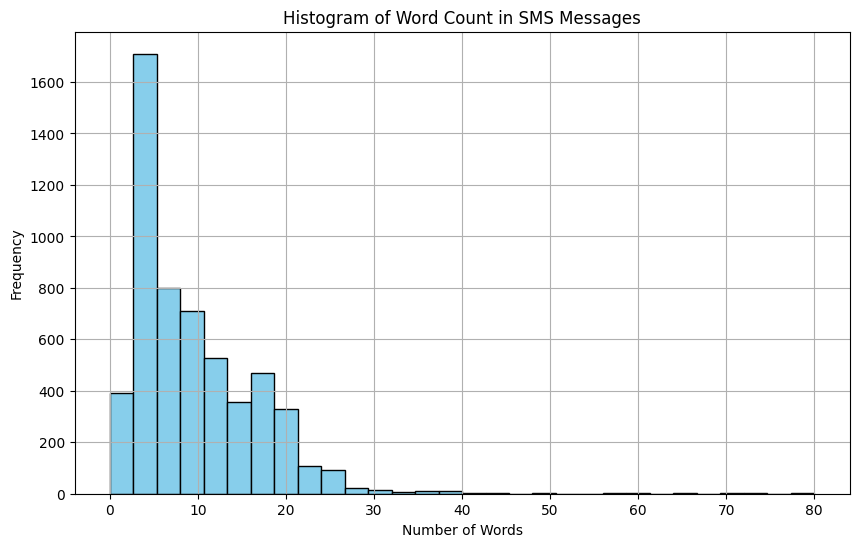

In [16]:
df['word_count'] = df['clean_lem_message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count in SMS Messages')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

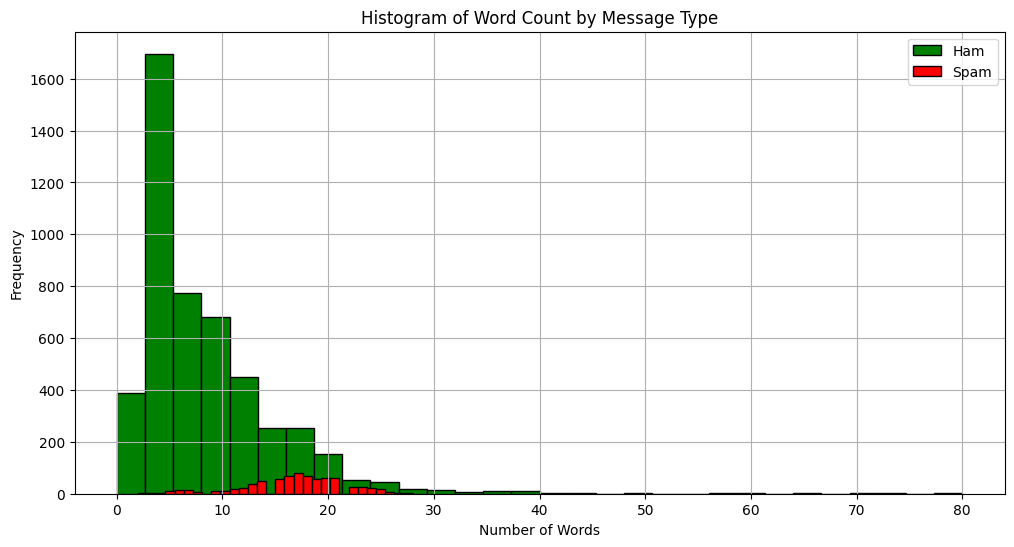

In [18]:
plt.figure(figsize=(12, 6))

# Ham
plt.hist(df[df['label'] == 'ham']['word_count'], bins=30,  label='Ham', color='green', edgecolor='black')

# Spam
plt.hist(df[df['label'] == 'spam']['word_count'], bins=30, label='Spam', color='red', edgecolor='black')

plt.title('Histogram of Word Count by Message Type')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()